## Exercise 2 (**Car acoustics, autoencoders and Gaussian processes**)

When designing sport cars, running a comprehensive acoustic analysis is fundamental to ensure a cabin environment that minimizes intrusive sounds, such as wind and road noise. To this end, **engineers rely on mathematical tools such as the Helmholtz equation to predict and analyze sound behavior in and around the vehicle**. This equation, in fact, is instrumental in studying how sound propagates within the cabin and how structural vibrations contribute to the overall acoustic profile.

To simplify things, let us consider the computational domain in Figure 2 representing a (simplified) longitudinal section of a sport car. Sound waves, caused, e.g., by wind gusts or engine functioning, enter the vehicle from $\Gamma_{\text{in}} \subset \partial \Omega$, propagate throughout the computational domain, and exit through the exhaust and the vents placed on the back, $\Gamma_{\text{out}} \subset \partial \Omega$. Using a **time-harmonic formulation**, we model the **acoustic pressure** $p : \Omega \to \mathbb{C}$ as the solution to the following **Helmholtz equation**  

$$
-\Delta p = \kappa^2 p \quad \text{in } \Omega,
\tag{5}
$$

subject to boundary conditions

$$
\begin{cases}
p = 1  & \text{on } \Gamma_{\text{in}} \\
\nabla p \cdot \mathbf{n} = i \kappa p & \text{on } \Gamma_{\text{out}} \\
\nabla p \cdot \mathbf{n} = 0 & \text{on } \partial \Omega \setminus (\Gamma_{\text{in}} \cup \Gamma_{\text{out}}),
\end{cases}
$$

where $i$ is the imaginary unit, $\operatorname{Re}(p)$ describes the physical acoustic pressure, whereas $\operatorname{Im}(p)$ models phase shifts. Given $p$, we postprocess the **sound intensity field** $u : \Omega \to \mathbb{R}$ as $u = |p|$. The **wave number**, $\kappa = \kappa(x,y)$, is given as

$$
\kappa(x,y) = \frac{2\pi f}{c(x,y)},
$$

with $f$ the frequency of the sound wave and $c = c(x,y)$ the speed of sound, here depending on the acoustic properties of the material at the point $(x,y) \in \Omega$. To distinguish between the main body of the car and the wheels, which have substantially different acoustic properties, we model $c$ as  

$$
c(x,y) =
\begin{cases}
343 & (x,y) \in \Omega \setminus (W_1 \cup W_2) \\
m & (x,y) \in W_1 \cup W_2
\end{cases}
$$

with $W_1, W_2 \subset \Omega$ the two subregions corresponding to the car wheels: see **Figure 2**. In order to **capture multiple scenarios**, we let  

$$
800 \leq f \leq 900 \quad \text{and} \quad 150 \leq m \leq 250,
$$  

modeling **uncertainties** in the actual frequency of the sound waves and potential modifications in the material properties of the wheels.


In [ ]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

from IPython.display import clear_output as clc
import gdown
import numpy as np

# Data
gdown.download(id = "1fMWdmZvKYlv_fHoPXoo-WdrC5i0U8x13", output = "carmesh.xml")
gdown.download(id = "1rsF2-0tKXZ6aHmJdsXsEGTWOwgzkoQky", output = "car_data.npz")

mesh = fe.loadmesh("carmesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()

dataset = np.load("car_data.npz")
mu, u = dataset["mu"], dataset["u"]

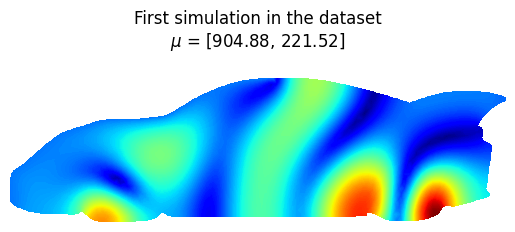

In [ ]:
# Visualization
fe.plot(u[0], Vh)
plt.title("First simulation in the dataset\n$\mu$ = [%.2f, %.2f]\n" % tuple(mu[0]))
None

Let $\mu = [f, m]^\top$ be the vector of model parameters. You are given access\(^*\) to a dataset of $N = 200$ pre-computed random simulations of the sound intensity field, obtained for different values of the problem parameters, $\{\mu_i, \mathbf{u}_{\mu_i}\}_{i=1}^{N}$. The dataset was constructed by drawing random values for $\mu$ (independently and uniformly in the parameter space) and then solving (6) using a Finite Element solver. In the dataset, each PDE solution is represented as a discrete vector, $\mathbf{u}_{\mu_i} \approx \mathbf{u}_{\mu_i}$, with $N_h = 2095$ degrees of freedom.

We are interested in deriving a minimal latent representation for PDE solutions arising from Eq. (5). Using 150 simulations for training and 50 for testing,





## a)
Extract a POD basis with $n_{\text{POD}} = 20$ modes and compute the average relative projection error — in Euclidean norm — over the test set;




In [ ]:
u.shape

(200, 2095)

In [ ]:
import numpy as np
from numpy.linalg import svd

In [ ]:
N = u.shape[0]
n_train = 150
n_test = N - n_train

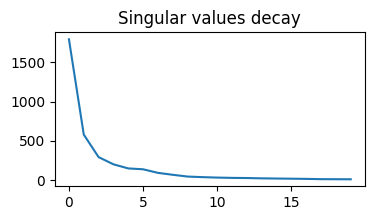

In [ ]:
X, s, Yt = svd(u[:n_train].T, full_matrices=False)

plt.figure(figsize = (4, 2))
plt.plot(s[0:20])
plt.title("Singular values decay")
plt.show()

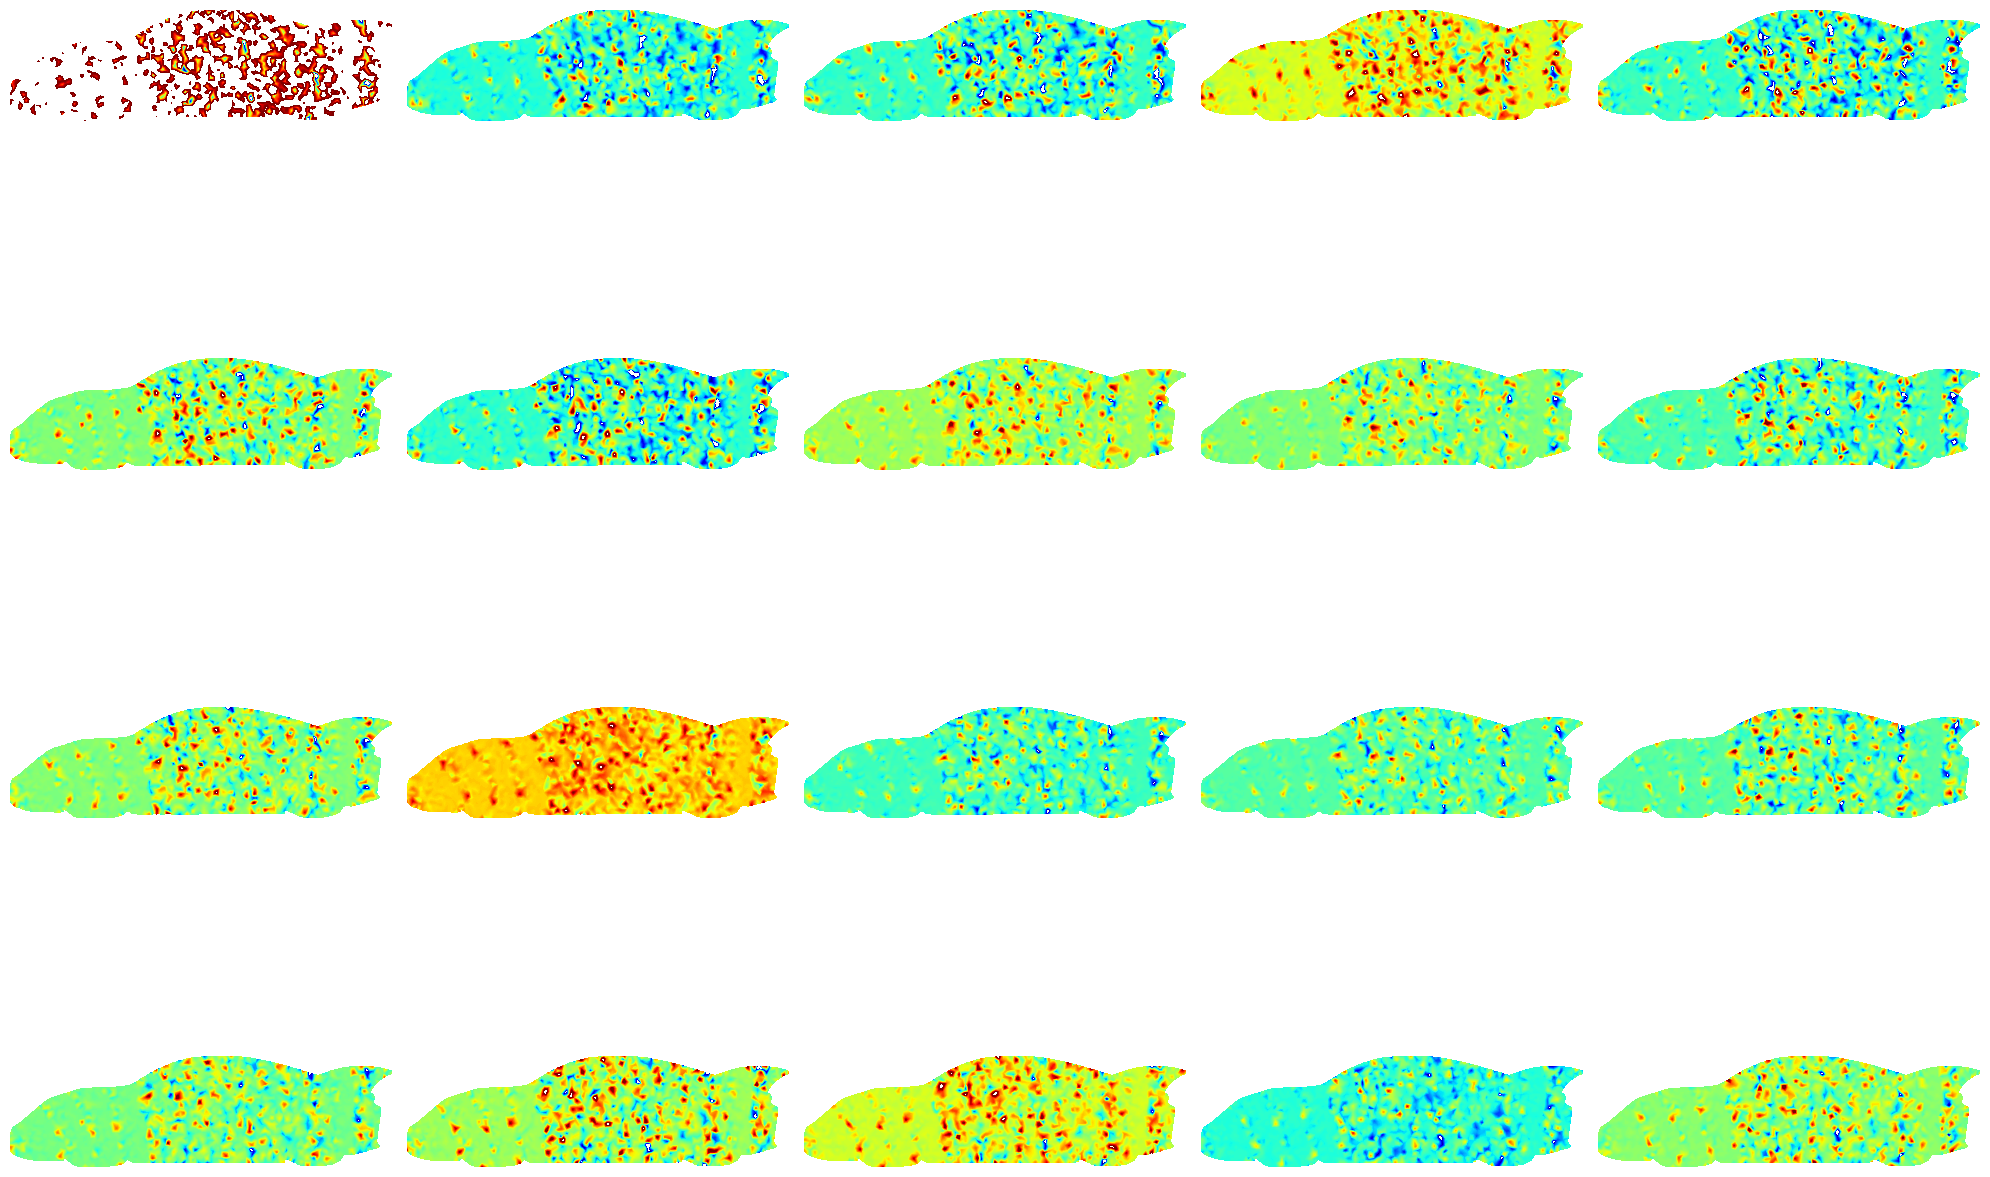

In [ ]:
n = 20
V = X[:, :n]
fe.multiplot(V.T, (4, 5), Vh)
plt.tight_layout()

In [ ]:
from dlroms import*
mu, u, V = dv.tensor(mu, u, V)
l2 = L2(Vh)
l2.moveOn(dv)
clc()

In [ ]:
uproj = u @ V @ V.T
avg_proj_error = mre(l2)(u[n_train:], uproj[n_train:])
print("Average projection error: %s." % num2p(avg_proj_error))

Average projection error: 1.79%.



## b)
Design and train a deep autoencoder with latent dimension $n_{\text{AE}} = 5$. Make sure that, after training, the autoencoder performs sufficiently well, with an average relative error ideally below 2%.


In [ ]:
from dlroms import*

In [ ]:
latent_dim = 5
N_h = u.shape[1]

encoder = Dense(N_h, 50) + Dense(50, latent_dim)
decoder = Dense(latent_dim, 50) + Dense(50, 100) + Dense(100, N_h, activation = None)
autoencoder = DFNN(encoder + decoder)

In [ ]:
autoencoder.He()
autoencoder.train(u, u, ntrain = n_train-25, nvalid=25, epochs = 100, loss = mse(l2))

		Train		Valid		Test
Epoch 100:	2.02e-04	5.03e-03	1.49e-03.

>> ETA: 2.22s.

Training complete. Elapsed time: 3 minutes 41.34 seconds.


In [ ]:
u_pred = autoencoder(u[n_train:])
u_pred.shape

torch.Size([50, 2095])

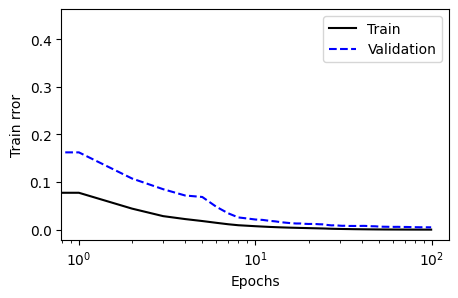

In [ ]:
autoencoder.freeze()
n_epochs = len(autoencoder.errors['Train'])
plt.figure(figsize = (5, 3))
plt.semilogx(autoencoder.errors['Train'], '-k', label = 'Train')
plt.semilogx(autoencoder.errors['Validation'], '--b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Train rror')
plt.legend()
plt.show()

In [ ]:
mre(l2)(u[n_train:], u_pred)

tensor(0.0258, grad_fn=<MeanBackward0>)


## c)

The car company you are collaborating with is impressed by the compression rate of the deep autoencoder, but, at the same time, they are worried about the reliability of the model, since reconstruction errors seem to be heterogeneous across the parameter space. To address this fact, they ask you to complement the approach by deriving a suitable error estimator.

Let $\{e_{\mu_i}\}_{i=1}^{200}$ be the relative reconstruction errors of the autoencoder across the whole dataset,

$$
\mathbf{e}_{\mu_i} := \frac{\|\mathbf{u}_{\mu_i} - \Psi(\Psi' (\mathbf{u}_{\mu_i}))\|}{\|\mathbf{u}_{\mu_i}\|},
$$

where $\Psi \circ \Psi'$ is the model at point (b). Leveraging the first 150 samples in $\{\mu_i, e_{\mu_i}\}_{i=1}^{200}$, fit a suitable Gaussian process regression model (GPR) to approximate the map

$$
\mathbb{R}^2 \ni \mu \mapsto e_{\mu} \in \mathbb{R}.
$$


In [ ]:
import torch

In [ ]:
tmp =  autoencoder(u[1])
u[1].shape, tmp.shape

(torch.Size([2095]), torch.Size([2095]))

In [ ]:
err_data = torch.zeros(N)

for i in range(N):
    err_data[i] = mre(l2)(u[i].unsqueeze(0) , autoencoder(u[i].unsqueeze(0)))

err_data.mean(), err_data.std(), err_data.shape

(tensor(0.0212), tensor(0.0270), torch.Size([200]))

In [ ]:
gp_x_train = mu[:n_train].detach().numpy()
gp_y_train = err_data[:n_train].detach().numpy()
gp_x_test = mu[n_train:].detach().numpy()
gp_y_test = err_data[n_train:].detach().numpy()

In [ ]:
gp_x_train.shape, gp_y_train.shape, err_data.min(), err_data.max()

((150, 2), (150,), tensor(0.0033), tensor(0.2847))

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [ ]:
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
##gp_y_train_scaled = scaler.fit_transform(gp_y_train.reshape(-1, 1)).ravel()

In [ ]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=[10, 10])


In [ ]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10)
gp.fit(gp_x_train, gp_y_train)


GaussianProcessRegressor(alpha=1e-06, kernel=1**2 * RBF(length_scale=[10, 10]),
                         n_restarts_optimizer=10)

In [ ]:
gp_y_pred, gp_y_std = gp.predict(gp_x_test, return_std=True)
#gp_y_pred = scaler.inverse_transform(gp_y_pred_scaled.reshape(-1, 1)).ravel()
#gp_y_std = scaler.scale_ * gp_y_std_scaled  # Rescale std


In [ ]:
mre = np.mean(np.abs((gp_y_test - gp_y_pred) / gp_y_test))
print(f"Mean Relative Error (MRE): {mre:.4f}")

Mean Relative Error (MRE): 0.3586


In [ ]:
gp_y_std

array([0.01486569, 0.01359852, 0.03370932, 0.02070197, 0.01428538,
       0.02176589, 0.01753735, 0.00845048, 0.01606293, 0.017576  ,
       0.01687587, 0.02007936, 0.03033301, 0.01255405, 0.02303573,
       0.02148146, 0.00805797, 0.00580604, 0.0071336 , 0.02502016,
       0.00848088, 0.02565425, 0.00618252, 0.01375654, 0.03042736,
       0.01754325, 0.02611371, 0.01017782, 0.00171175, 0.02524671,
       0.02908209, 0.02796349, 0.01560696, 0.03177388, 0.01779617,
       0.0219037 , 0.0139588 , 0.02317796, 0.00925891, 0.01529227,
       0.00833074, 0.00732603, 0.01636073, 0.02115345, 0.02478942,
       0.00853847, 0.01247546, 0.00867018, 0.01210686, 0.02562209])


## d)
For any $\mu$ in the parameter space, let $g(\mu)$ and $\sigma(\mu)$ be the predicted mean and the predicted variance returned by the GPR at point (c). Use the test set to estimate the smallest coefficient $\beta > 0$ for which

$$
\mathbb{P} (e_{\mu} > g(\mu) - \beta \sigma(\mu)) \geq 95%.
$$

In [ ]:
gp_y_test - gp_y_pred

array([ 3.52747003e-02,  4.13789866e-03,  2.40158935e-02,  5.31980734e-03,
        3.74678343e-04,  3.14726906e-03,  4.75776426e-03,  1.64572828e-03,
        9.41754702e-03,  2.90485435e-02,  1.92155438e-02,  2.32778554e-02,
        7.27896659e-03,  1.24850762e-03,  8.06611016e-03,  2.34471578e-03,
        7.24148141e-04,  3.58289653e-05,  5.62561047e-04,  4.07917231e-03,
        1.10378672e-02,  3.88438179e-03,  1.43406945e-01,  2.26328203e-03,
        4.30646986e-04,  1.27426567e-02,  4.25083525e-02, -4.32906750e-05,
        1.26250616e-03,  6.49850439e-02,  1.47768176e-02, -5.47728885e-03,
        1.09952592e-02,  1.52694068e-02, -2.80181287e-03,  1.28498803e-03,
        1.44600414e-03,  5.35489045e-03, -2.68116809e-04,  2.21924765e-03,
        7.46986514e-04,  9.74441062e-03,  3.42123656e-03,  8.73017167e-03,
        8.33326038e-03, -4.66830796e-03, -7.86404266e-04, -2.33160933e-04,
        2.32459784e-04,  8.18531789e-03])

In [ ]:
z_values = (gp_y_test - gp_y_pred) / gp_y_std
z_values.shape

(50,)

In [ ]:
z_values.mean(), z_values.std()

(0.8874952508167984, 3.24585398040149)

In [ ]:
from scipy.stats import norm

In [ ]:
beta = np.percentile(z_values, 5)  # 5th percentile
beta

-0.11495774532065034

In [ ]:
E_mu = gp_y_pred - beta * gp_y_std
prob_satisfied = np.mean(gp_y_test > E_mu)
print(f"Probability bound satisfied: {prob_satisfied:.2%}")


Probability bound satisfied: 64.00%



## e)
Let $\mathbf{E}(\mu) := g(\mu) - \beta \sigma(\mu)$ be your _error estimator from below_. Compute $\mathbf{E}(\mu)$ on a uniform grid over $[800, 900] \times [150, 250]$ and plot the result. Which region of the parameter space corresponds to PDE solutions posing a major challenge for the autoencoder? Consider the simulation in the test set for which the autoencoder yields the worst performance: is that contained in the region you just identified?

In [ ]:
# Define grid resolution
f_vals = np.linspace(800, 950, 100)
m_vals = np.linspace(150, 250, 100)

# Create mesh grid
F, M = np.meshgrid(f_vals, m_vals)
grid_points = np.vstack([F.ravel(), M.ravel()]).T

In [ ]:
gp_mean, gp_std = gp.predict(grid_points, return_std=True)  # Predict mean and std
#gp_mean = scaler.inverse_transform(gp_mean_scaled.reshape(-1, 1)).ravel()
#gp_std = scaler.scale_ * gp_std_scaled  # Rescale std

In [ ]:
E_mu = gp_mean - beta * gp_std
E_mu_grid = E_mu.reshape(F.shape)

In [ ]:
i = np.argmax(gp_y_test)
worst_mu = gp_x_test[i]
worst_mu

array([864.9402 , 162.46082], dtype=float32)

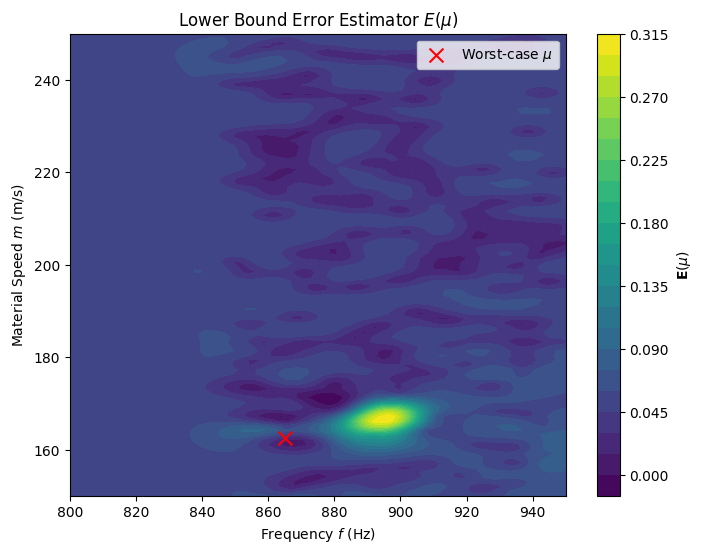

In [ ]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(F, M, E_mu_grid, levels=30, cmap="viridis")
plt.colorbar(contour, label=r"$\mathbf{E}(\mu)$")
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("Material Speed $m$ (m/s)")
plt.title("Lower Bound Error Estimator $E(\\mu)$")

# Plot the worst-case scenario
plt.scatter(worst_mu[0], worst_mu[1], color='red', marker='x', s=100, label="Worst-case $\mu$")
plt.legend()
plt.show()
